In [1]:
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

import sys
sys.path.append('../../')

from astroLuSt.database_interface import (
    database_utils as aldidu,
    tesscut_interface as aldate,
)
from astroLuSt.preprocessing import (
    images as alprim,
    photometry as alprph,
)
from astroLuSt.synthetics import images as alsyim

np.random.seed(0)

import importlib
importlib.reload(alprph)
importlib.reload(alsyim)

#style for plotting
plt.style.use('astroLuSt.styles.LuSt_style')

2024-11-07 11:17:27.745905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Get Data

### Science Objects

In [2]:
importlib.reload(aldate)

#define targets
df_targets = pl.from_dicts([
    dict(coords=SkyCoord("19 25 27.9129605304 +42 47 03.693258204", frame="icrs", unit=(u.hourangle, u.deg)), name="RRLyr", sectors=[14,40],   period=0.5667732268824381),
    dict(coords=SkyCoord("14 16 36.5814789480 +42 21 35.712985824", frame="icrs", unit=(u.hourangle, u.deg)), name="TVBoo", sectors=[1,16,23], period=0.3125589785657776),
])
display(df_targets)


#instantiate
TCI = aldate.TESScut_Interface(
    n_jobs=5,
    redownload=False,
    sleep=.5,
    verbose=1,
)

#download
hdulists = TCI.download(
    coordinates=df_targets["coords"],
    sectors=df_targets["sectors"],
    targ_ids=df_targets["name"],
    combine_sectors=True,       #combine all downloaded sectors into one array
    ffi_header_keys=["TELESCOP"],
    prim_header_keys=["TELESCOP", "INSTRUME"],
    col_keys=["SECTOR","EXPOSURE"],
    n_jobs=None,
    savedir=f"../_data/",
    # savedir=None,             #don't save
    filenames=None,             #autogenerate
    verbose=None,
    parallel_kwargs=dict(backend="threading"),
    get_cutouts_kwargs=dict(size=[15,20], product="SPOC"),
)


coords,name,sectors,period
object,str,list[i64],f64
"<SkyCoord (ICRS): (ra, dec) in deg (291.366304, 42.78435924)>","""RRLyr""","[14, 40]",0.566773
"<SkyCoord (ICRS): (ra, dec) in deg (214.15242283, 42.35992027)>","""TVBoo""","[1, 16, 23]",0.312559


In [3]:
#in case you already have the files downloaded
hdulists = [fits.open(f'../_data/{name}_cutouts.fits') for name in df_targets['name']]    #load in same order as input dataframe (and hence coords)
print(hdulists)
print(len(hdulists))

tpfs = [hdul[1].data.field('FLUX').copy() for hdul in hdulists]
tpfs_e = [hdul[1].data.field('FLUX_ERR').copy() for hdul in hdulists]
times = [hdul[1].data.field('TIME').copy() for hdul in hdulists]
sectors = [hdul[1].data.field('SECTOR').copy() for hdul in hdulists]

print(tpfs[0].shape, tpfs_e[0].shape)

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x72acc12bf400>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x72acc12bd960>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x72acc12b24a0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x72acc114be80>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x72acc1149ea0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x72acc12bf2e0>]]
2
(5168, 15, 20) (5168, 15, 20)


### Constant Reference Objects

In [4]:
npix = 20
radius = npix*21/3600 #`npix` tess pixels

for idx in range(len(tpfs)):
    #extract potential reference ojects
    ref_tab = aldidu.get_reference_objects(coords=df_targets["coords"][idx], radius=radius)

    #get object closest to variable star
    ref = ref_tab[np.argsort(ref_tab['distance'])][-1:]
    display(ref)

    hdulists = TCI.download(
        coordinates=[SkyCoord(ref_tab["ra"], ref_tab["dec"])],
            sectors=[df_targets["sectors"][idx]],
            targ_ids=[f"{df_targets['name'][idx]}_ref"],
            combine_sectors=True,       #combine all downloaded sectors into one array
            ffi_header_keys=["TELESCOP"],
            prim_header_keys=["TELESCOP", "INSTRUME"],
            col_keys=["SECTOR","EXPOSURE"],
            n_jobs=None,
            savedir=f"../_data/",
            # savedir=None,             #don't save
            filenames=[f"{df_targets['name'][idx]}_ref"],
            verbose=None,
            parallel_kwargs=dict(backend="threading"),
            get_cutouts_kwargs=dict(size=[15,20], product="SPOC"),        
    )

#in case you already have the files downloaded
hdulists = [fits.open(f'../_data/{name}_ref_cutouts.fits') for name in df_targets['name']]    #load in same order as input dataframe (and hence coords)
print(hdulists)
print(len(hdulists))

tpfs_ref = [hdul[1].data.field('FLUX').copy() for hdul in hdulists]
tpfs_e_ref = [hdul[1].data.field('FLUX_ERR').copy() for hdul in hdulists]
times_ref = [hdul[1].data.field('TIME').copy() for hdul in hdulists]
sectors_ref = [hdul[1].data.field('SECTOR').copy() for hdul in hdulists]

print(tpfs_ref[0].shape, tpfs_e_ref[0].shape)

oid,ra,dec,main_id,otype,ids,distance,vartyp_mesvar
,deg,deg,,,,,
int64,float64,float64,object,object,object,float64,object
23691476,291.306488,42.891705,LAMOST J192513.55+425330.1,*,KIC 7280469|LAMOST J192513.55+425330.1,0.11596106228741195,


oid,ra,dec,main_id,otype,ids,distance,vartyp_mesvar
,deg,deg,,,,,
int64,float64,float64,object,object,object,float64,object
21037280,214.15861818394293,42.26231737542833,Gaia DR3 1492228976169235200,*,Gaia DR3 1492228976169235200|Gaia DR2 1492228976169235200,0.09771036592599552,


[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x72acc114be80>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x72acc12b0310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x72acc12b2ec0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x72acc12b0d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x72acc12b0220>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x72acc12b26e0>]]
2
(5168, 15, 20) (5168, 15, 20)


# `Aperture`
* variety of aperture masks

In [7]:
importlib.reload(alprph)

#instantiate
APT = alprph.Aperture(
    size=(50,60),
    position=np.array([-10,-5]),
    npixels=1,
    outside=0.0,
    # outside=np.nan, #use for missing values outside of aperture
    verbose=1,
)

#define apertures
poly_coeffs = [-0.015, 0.16, 0, 10]     #coefficients to define aperture falloff
apertures = [
    dict(func=APT.lp_aperture,       radius=10,  p=1,   poly_coeffs=None),
    dict(func=APT.lp_aperture,       radius=10,  p=1.5, poly_coeffs=None),
    dict(func=APT.lp_aperture,       radius=10,  p=1.5, poly_coeffs=poly_coeffs),
    dict(func=APT.lp_aperture,       radius=10,  p=2,   poly_coeffs=[0,1]),
    dict(func=APT.lp_aperture,       radius=10,  p=2,   poly_coeffs=[-0.015, 0.16, 0, 10]),
    dict(func=APT.lp_aperture,       radius=10,  p=np.inf),
    dict(func=APT.rect_aperture,     width=10,   height=20),
    dict(func=APT.gauss_aperture,    radius=10,  p=0,       covariance=np.array([[10,-13],[-13,50]]), lp=False),
    dict(func=APT.gauss_aperture,    radius=10,  p=np.inf,  covariance=5, lp=False),
    dict(func=APT.gauss_aperture,    radius=10,  p=1,       covariance=5, lp=True),
    dict(func=APT.lorentz_aperture,  fwhm=np.array([20,30]),radius=np.inf,  p=0),
    dict(func=APT.lorentz_aperture,  fwhm=10,   radius=10,  p=np.inf),
]


### Default Utilization: Standard Apertures
- `radius_inner = 0.0`
- `width_inner = 0.0`
- `height_inner = 0.0`

/home/lukas/github/astroLuSt/demos/preprocessing/../../astroLuSt/preprocessing/photometry.py:631: UserWarning: The following kwargs were not used by contour: 'color'
  cont = ax1.contour(coords[:,:,0], coords[:,:,1], X, **contour_kwargs)


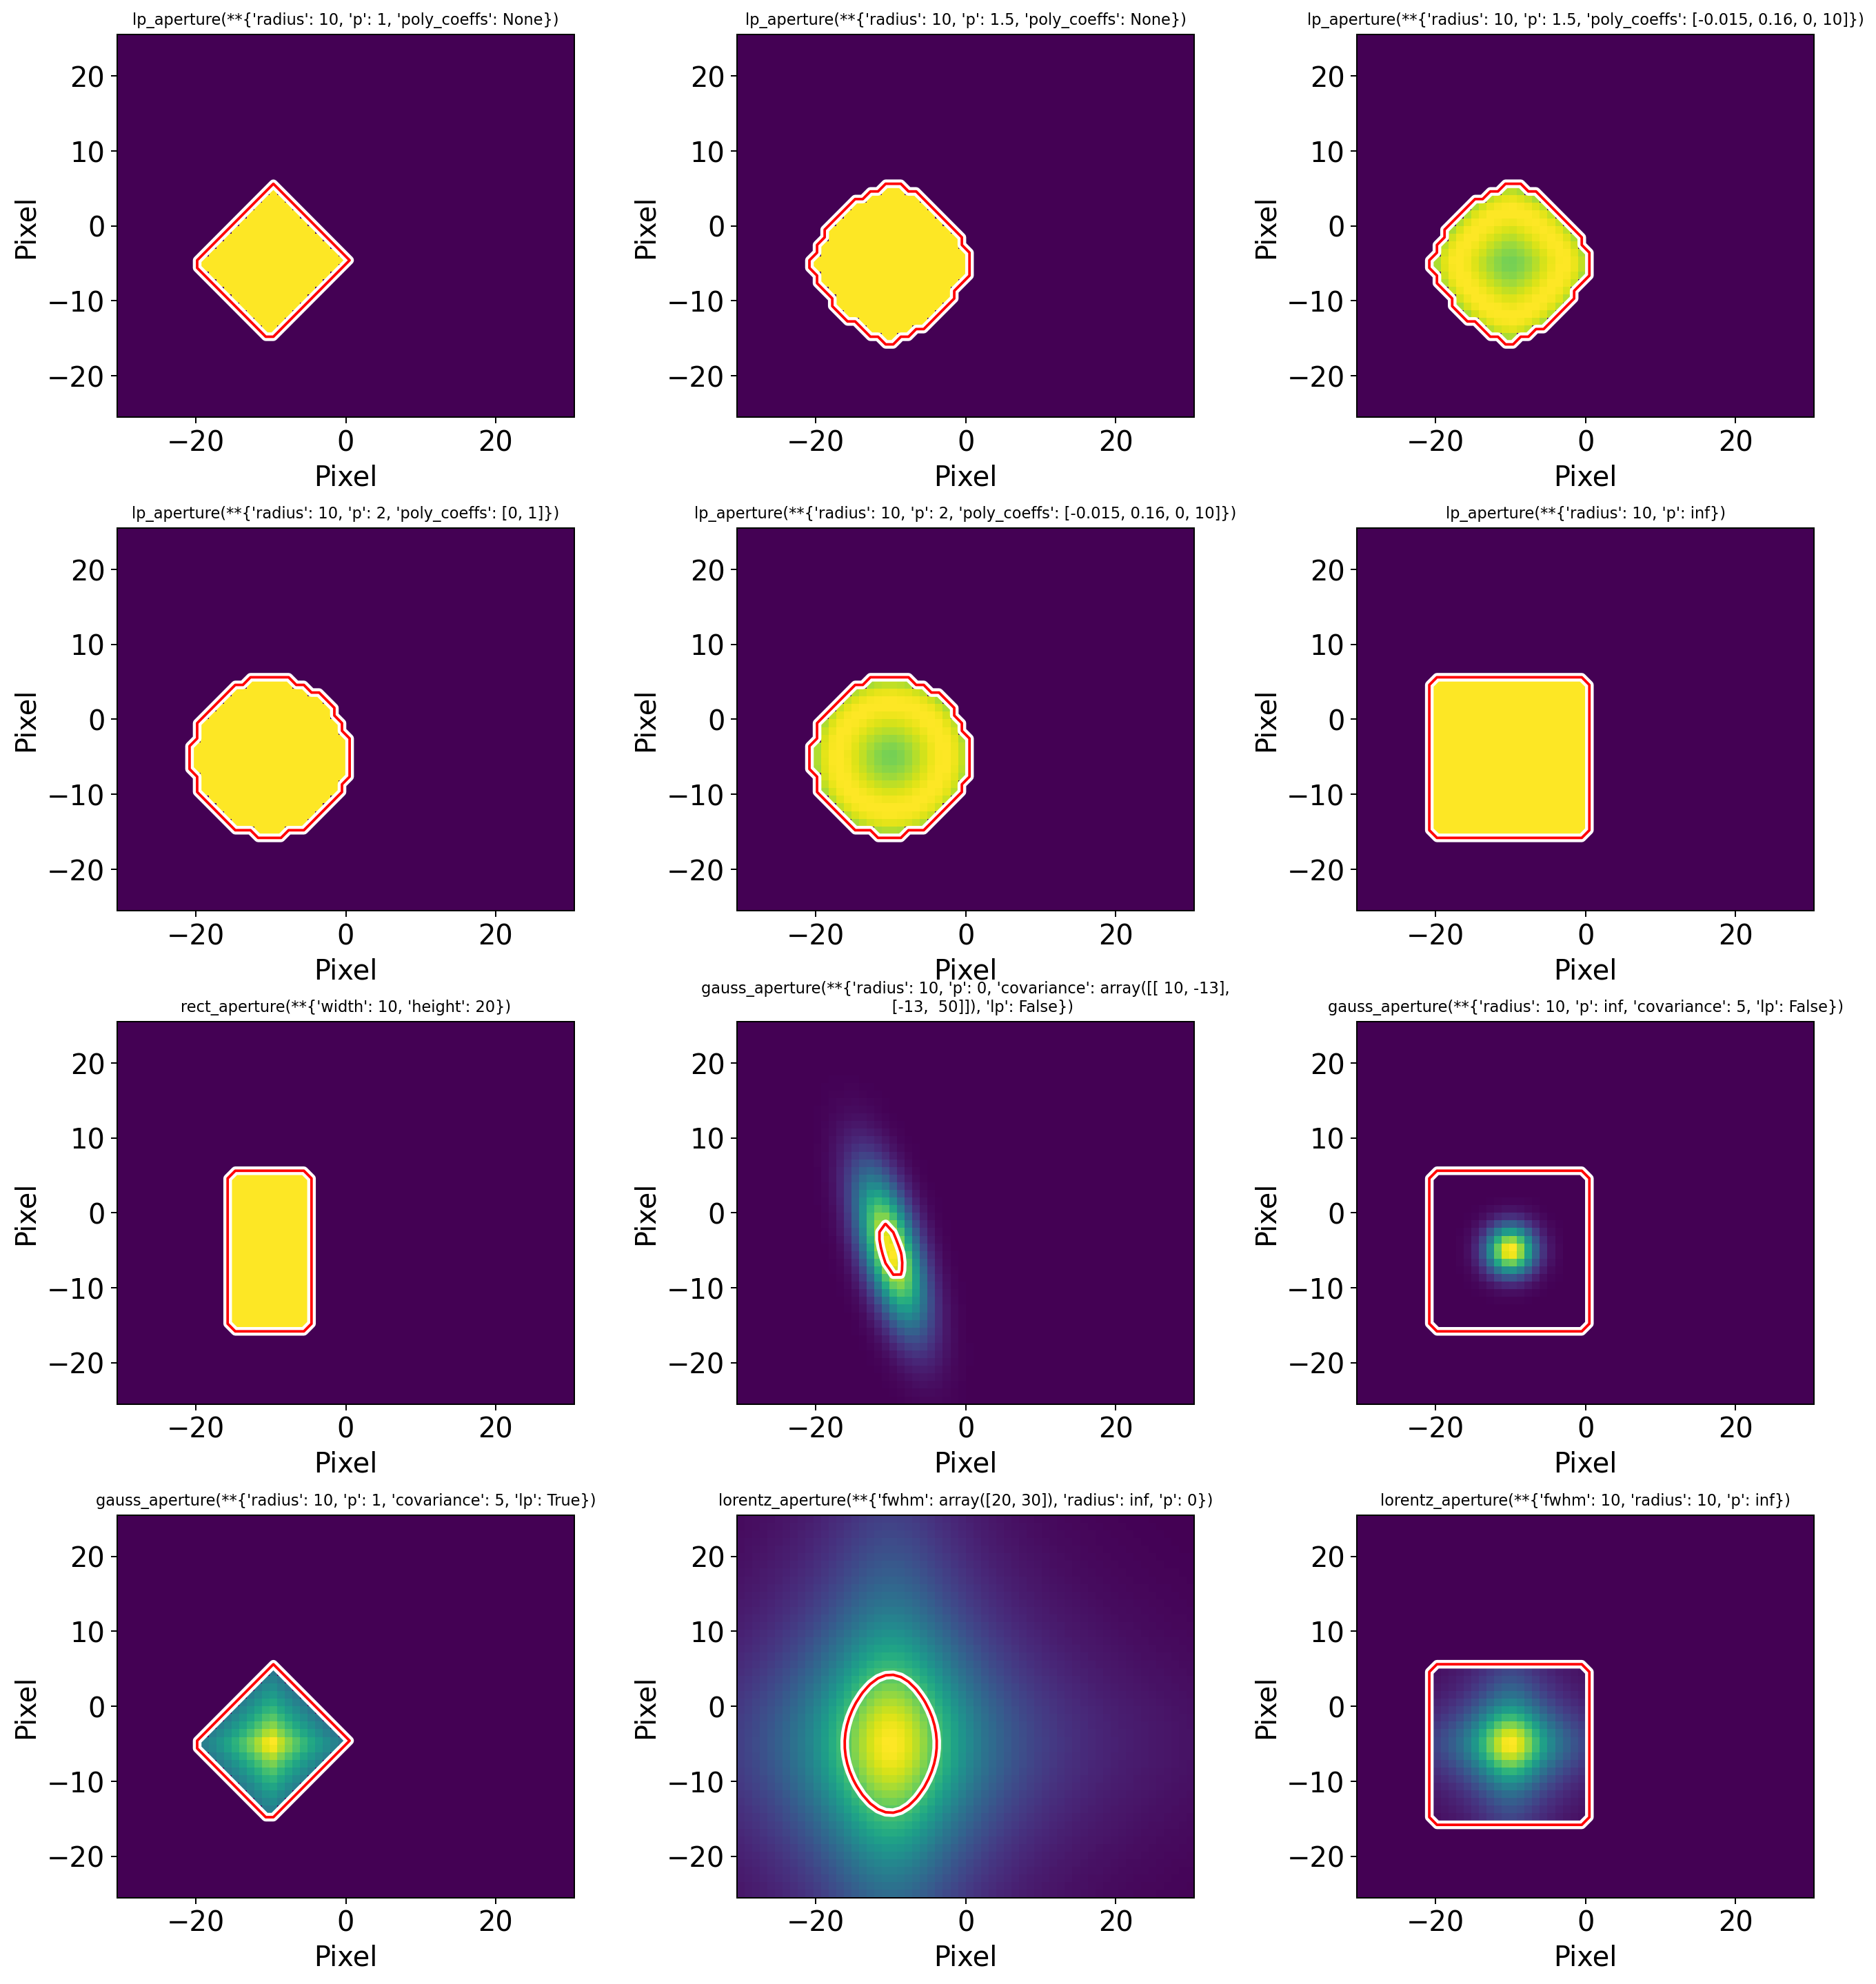

In [8]:
#plotting
ncols = 3
nrows = int(np.ceil(len(apertures)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
for idx, params in enumerate(apertures):
    
    #generate aperture
    func = params.pop('func')
    aperture = func(**params)
    
    #plot
    title = f'{func.__name__}(**{params})'
    ax = axes.flatten()[idx]
    ax.set_title(title, fontsize=9)
    fig, axs = APT.plot_result(
        aperture, ax=ax,
        pcolormesh_kwargs=dict(cmap='viridis'),
        contour_kwargs=dict(color='r', levels=0)
    )
    #remove color bar
    axs[-1].remove()

    #add func back into dict
    params['func'] = func

fig.tight_layout()

plt.show()


### Sky-Ring Generation
- `radius_inner != 0.0`
- `width_inner != 0.0`
- `height_inner != 0.0`

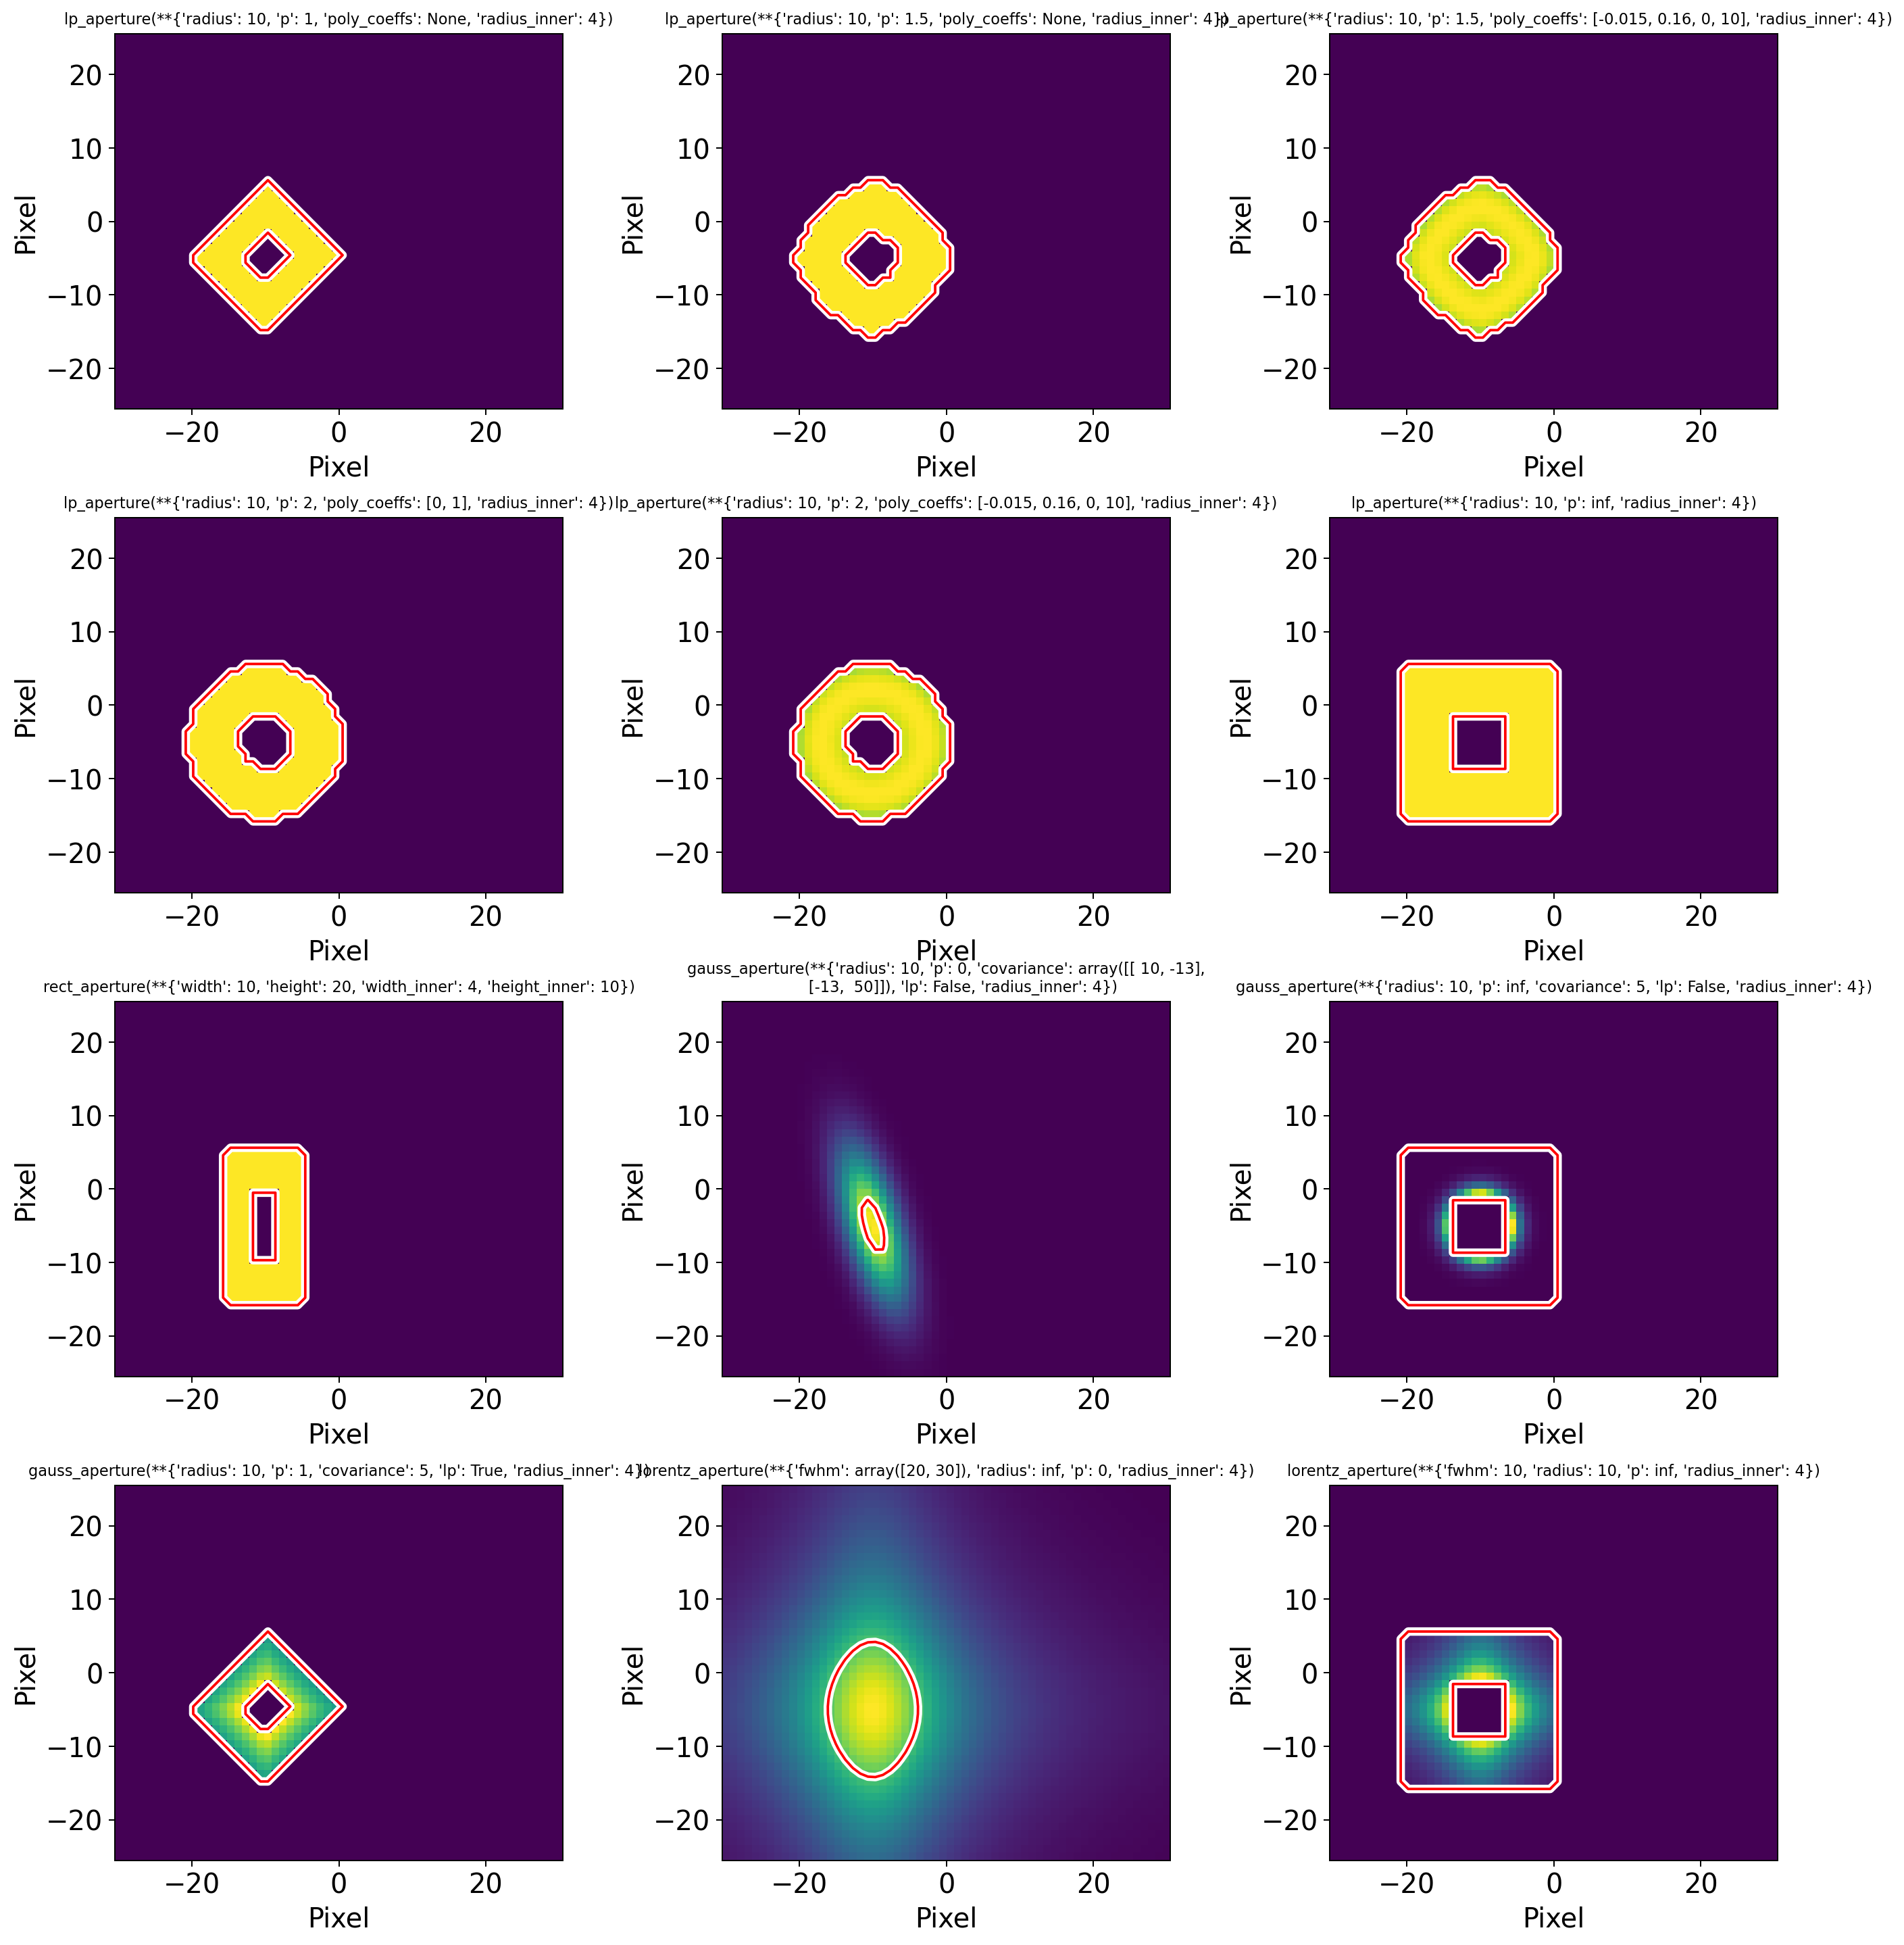

In [9]:
#add inner sky ring bounds
for i in range(len(apertures)):
    if apertures[i]['func'].__name__ == 'rect_aperture':
        apertures[i]['width_inner'] = 4
        apertures[i]['height_inner'] = 10
    else:
        apertures[i]['radius_inner'] = 4

#plotting
ncols = 3
nrows = int(np.ceil(len(apertures)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
for idx, params in enumerate(apertures):
    
    #generate aperture
    func = params.pop('func')
    aperture = func(**params)
    
    #plot
    title = f'{func.__name__}(**{params})'
    ax = axes.flatten()[idx]
    ax.set_title(title, fontsize=9)
    fig, axs = APT.plot_result(
        aperture, ax=ax,
        pcolormesh_kwargs=dict(cmap='viridis'),
        contour_kwargs=dict(color='r', levels=0)
    )
    #remove color bar
    axs[-1].remove()

fig.tight_layout()

plt.show()


# `AperturePhotometry()`
* Application of aperture photometry

In [10]:
#custom function to calculate variants of the fluxes
def sectornorm(
    X:np.ndarray, X_e:np.ndarray,
    sector:np.ndarray,
    eps:float=1e-9,
    ) -> np.ndarray[np.ndarray,np.ndarray]:
    """
        - function to compute a normalized version of X
        - computes
            - normalized X w.r.t. global median (and errors)
            - normalized X w.r.t. sectorwise median (and errors)

        Parameters
        ----------
            - `X`
                - `np.ndarray`
                - 1d
                - series of fluxes to be normalized
            - `X_e`
                - `np.ndarray`
                - same shape as `X`
                - errors corresponding to `X`
            - `sector`
                - `np.ndarray`
                - 1d
                - contains for each frame the sector it was observed in
            - `eps`
                - `float`, optional
                - constant for numerical stability upon division
                - relevant if median of LC is exactly `0.0`
        
        Raises
        ------

        Returns
        -------
            - `X_norm`
                - `np.ndarray`
                - contains normalized versions of `X`
                - 2d
                    - globallly normalized
                    - sector-wise normalized
            - `X_norm_e`
                - `np.ndarray`
                - contains errors corresponding to `X`
                - 2d
                    - globallly normalized
                    - sector-wise normalized

        Dependencies
        ------------
            - `numpy`
        
        Comments
        --------
    """
    #initialize
    X_norm = np.empty((X.shape[0],2))
    X_norm_e = np.zeros_like(X_norm)*np.nan
    
    #compute fluxes and errors
    X_norm[:,0] = X/np.nanmedian(X)
    X_norm_e[:,0] = X_e/np.nanmedian(X)
    for s in np.unique(sector):
        sbool = (sector==s)
        X_norm[sbool,1] = X[sbool] / (np.median(X[sbool]+eps))
        X_norm_e[sbool,1] = X_e[sbool] / (np.median(X[sbool])+eps)
    
    return X_norm, X_norm_e


Processing 1/2
Processing 2/2


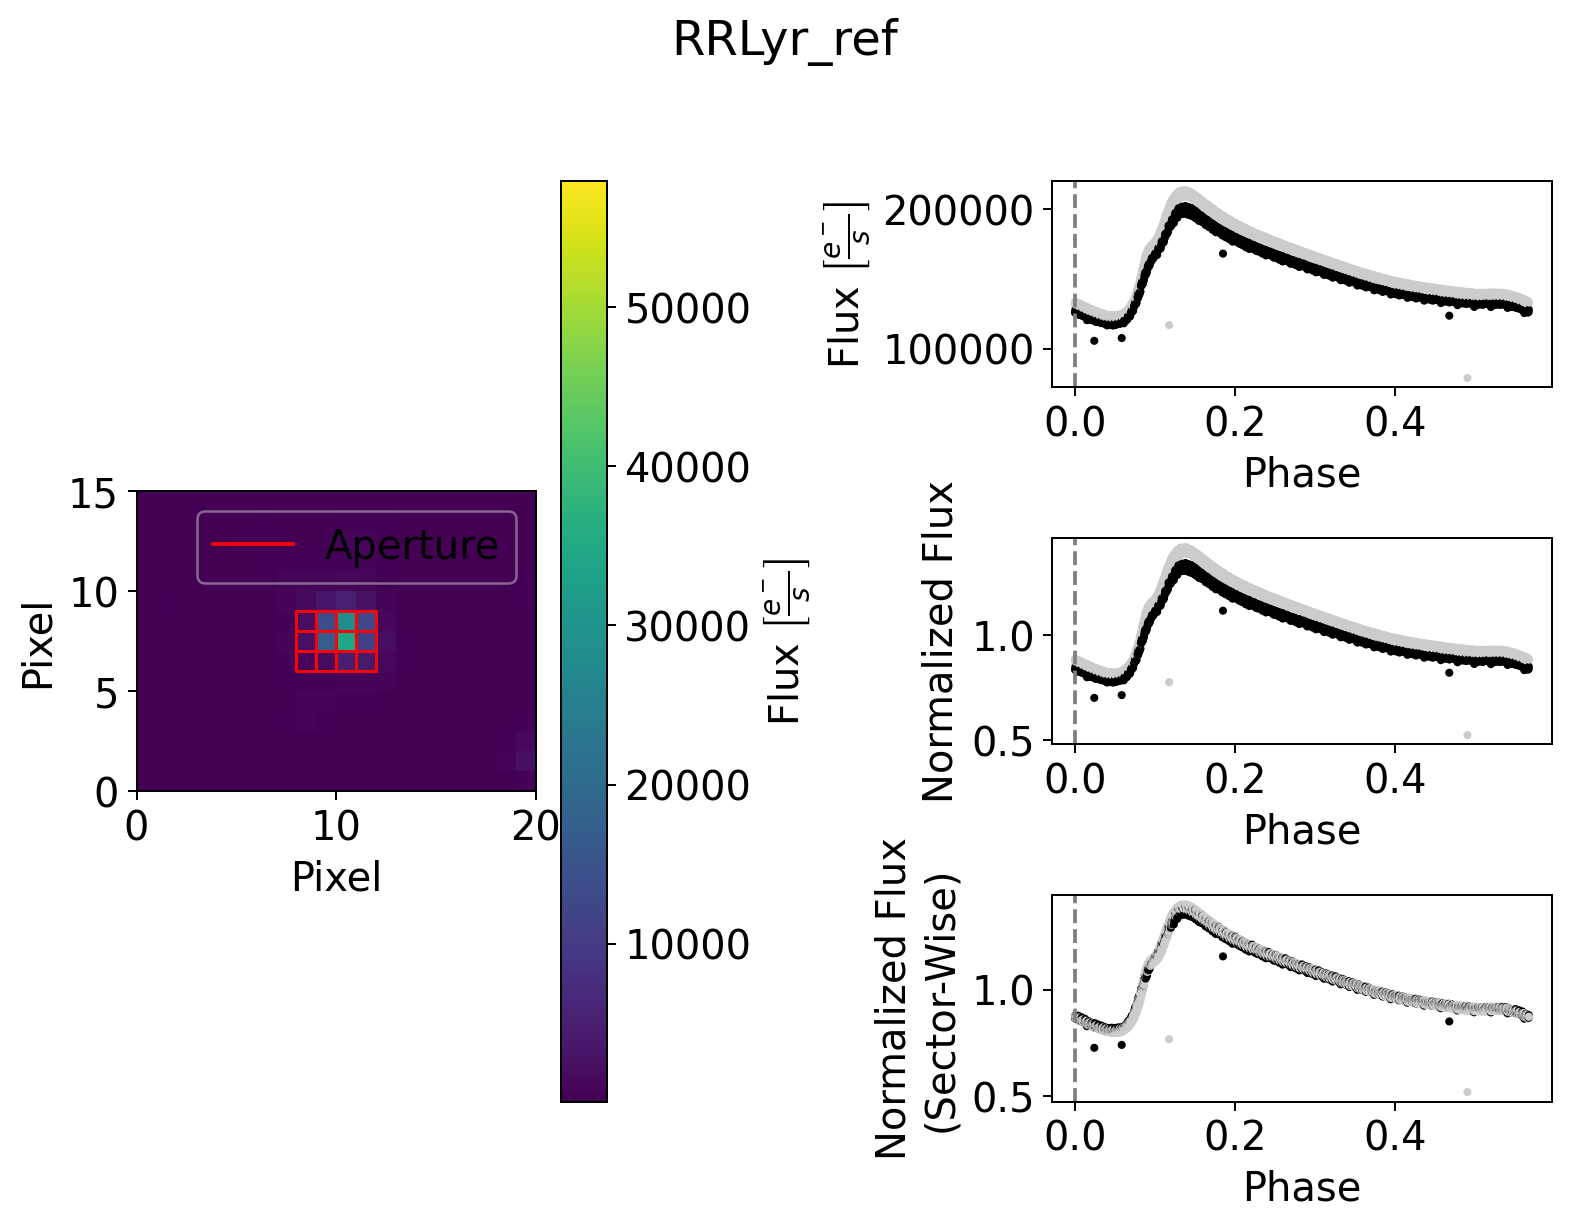

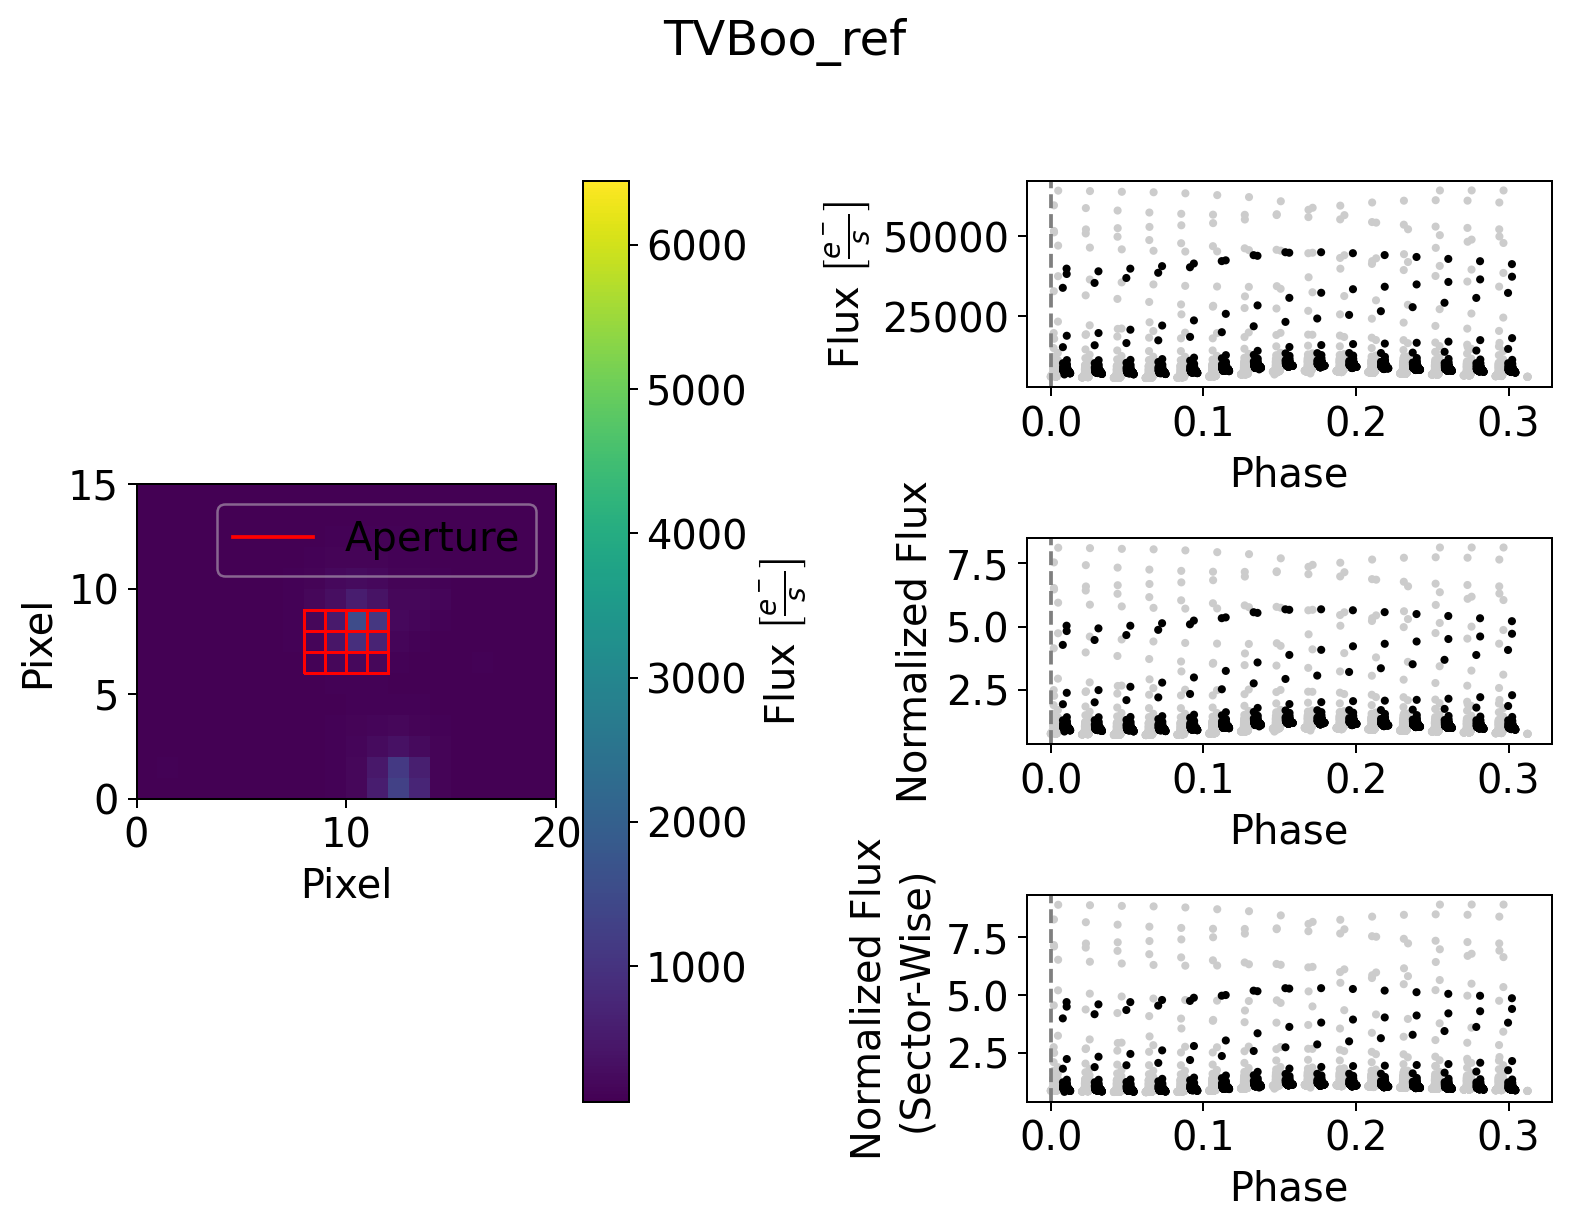

In [11]:
importlib.reload(alprph)
#instantiate
AP = alprph.AperturePhotometry(
    verbose=2,
)

#process
for idx in range(0,len(tpfs)):
    print(f"Processing {idx+1}/{len(tpfs)}")

    #applying Aperture Photometry
    AP.fit(
        X=tpfs[idx], y=None, X_e=tpfs_e[idx],
        aperture=2,
        fluxvars=sectornorm,
        # fluxvars=lambda x, x_e, **kwargs:(None, None),
        verbose=None,
        fluxvars_kwargs=dict(sector=sectors[idx]),
    )

    X_fluxes, X_fluxes_e, aperture = AP.transform(X=tpfs)

    #plotting
    x_vals = times[idx]%df_targets["period"][idx]    #periods
    sort_idxs = np.argsort(x_vals)
    Xf      = X_fluxes[     sort_idxs]
    Xf_e    = X_fluxes_e[   sort_idxs]
    x_vals  = x_vals[       sort_idxs]
    secs    = sectors[idx][ sort_idxs]
    tpfsi   = tpfs[idx][    sort_idxs]
    xlabs   = r'Phase'

    fig = plt.figure(figsize=(9,7))
    fig.suptitle((
        f'{hdulists[idx][0].header["TARGNAME"]}\n'
    ))

    fig, axs, anim = AP.plot_result(
        X=Xf, X_e=Xf_e,
        x_vals=x_vals, X_in=tpfsi, aperture=aperture,
        fig=fig,
        animate=True,
        pcolormesh_kwargs=None,
        sctr_kwargs=dict(c=secs, cmap='nipy_spectral', s=5, alpha=1),
        func_animation_kwargs=dict(repeat=False, frames=range(0,Xf.shape[0],100)),
    )
    axs[2].set_xlabel(xlabs)
    axs[3].set_xlabel(xlabs)
    axs[4].set_xlabel(xlabs)
    axs[1].set_ylabel(r'Flux $\left[\frac{e^-}{s}\right]$') #cbar
    axs[2].set_ylabel(r'Flux $\left[\frac{e^-}{s}\right]$')
    axs[3].set_ylabel(r'Normalized Flux')
    axs[4].set_ylabel('Normalized Flux\n(Sector-Wise)')

    anim.save(
        f'../_gfx/photometry_aperturephotometry_{df_targets["name"][idx]}.gif',
        writer='pillow',
        # savefig_kwargs=dict(bbox_inches='tight')
    )



# `BestAperture`
* Determining The Best Aperture

Generate a TPF timeseries

Shape of generated frames: (10, 15, 15, 3)


/home/lukas/github/astroLuSt/demos/preprocessing/../../astroLuSt/physics/photometry.py:385: RuntimeWarning: divide by zero encountered in log10
  m = -2.5*np.log10(f/f_ref) + m_ref
/home/lukas/github/astroLuSt/demos/preprocessing/../../astroLuSt/physics/photometry.py:388: RuntimeWarning: divide by zero encountered in divide
  dm =  df     *np.abs(-2.5*1/(np.log(10)*f)) \
/home/lukas/github/astroLuSt/demos/preprocessing/../../astroLuSt/physics/photometry.py:388: RuntimeWarning: invalid value encountered in multiply
  dm =  df     *np.abs(-2.5*1/(np.log(10)*f)) \


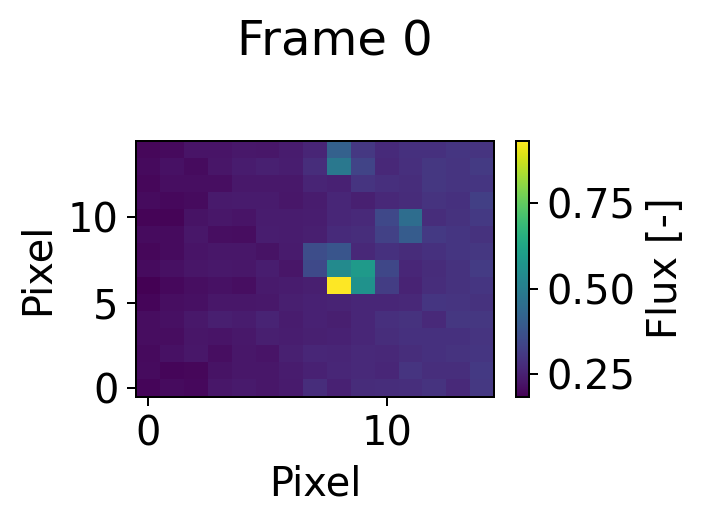

In [12]:
TPFS = alsyim.TPF_Series(
    size=15,
    # mode='mag',
    mode='flux',
    rng=None,
    verbose=0,
)

times_TPFS = np.linspace(0,10,10)

#one fixed star, 4 random stars
frames, starparams_s = TPFS.rvs(
    times=times_TPFS,
    variability=None,
    add_stars_kwargs=dict(
        nstars  =5,
        posx    =np.append([7.5], np.random.uniform(0,  15, (4))),
        posy    =np.append([7.5], np.random.uniform(0,  15, (4))),
        f       =np.append([1],   np.random.uniform(0.1, 1, (4))),
        m       =np.append([-2.5],np.random.uniform(-2,  0, (4))),
        aperture=np.append([1],   np.random.uniform(1,   2, (4))),
    ),
    add_noise_kwargs=dict(amplitude=1, bias=1E-1),
    add_custom_kwargs=dict(trend='linearx', amplitude=1E-1),
)

fig = plt.figure(figsize=(4,3))
fig, axs, anim = TPFS.plot_result(fig=fig)

print(f'Shape of generated frames: {frames.shape}')

plt.show()

analyze

BestAperture(
    mode='flux',
    store_ring_mask=True,
    store_aperture_masks=True,
    verbose=0,
)


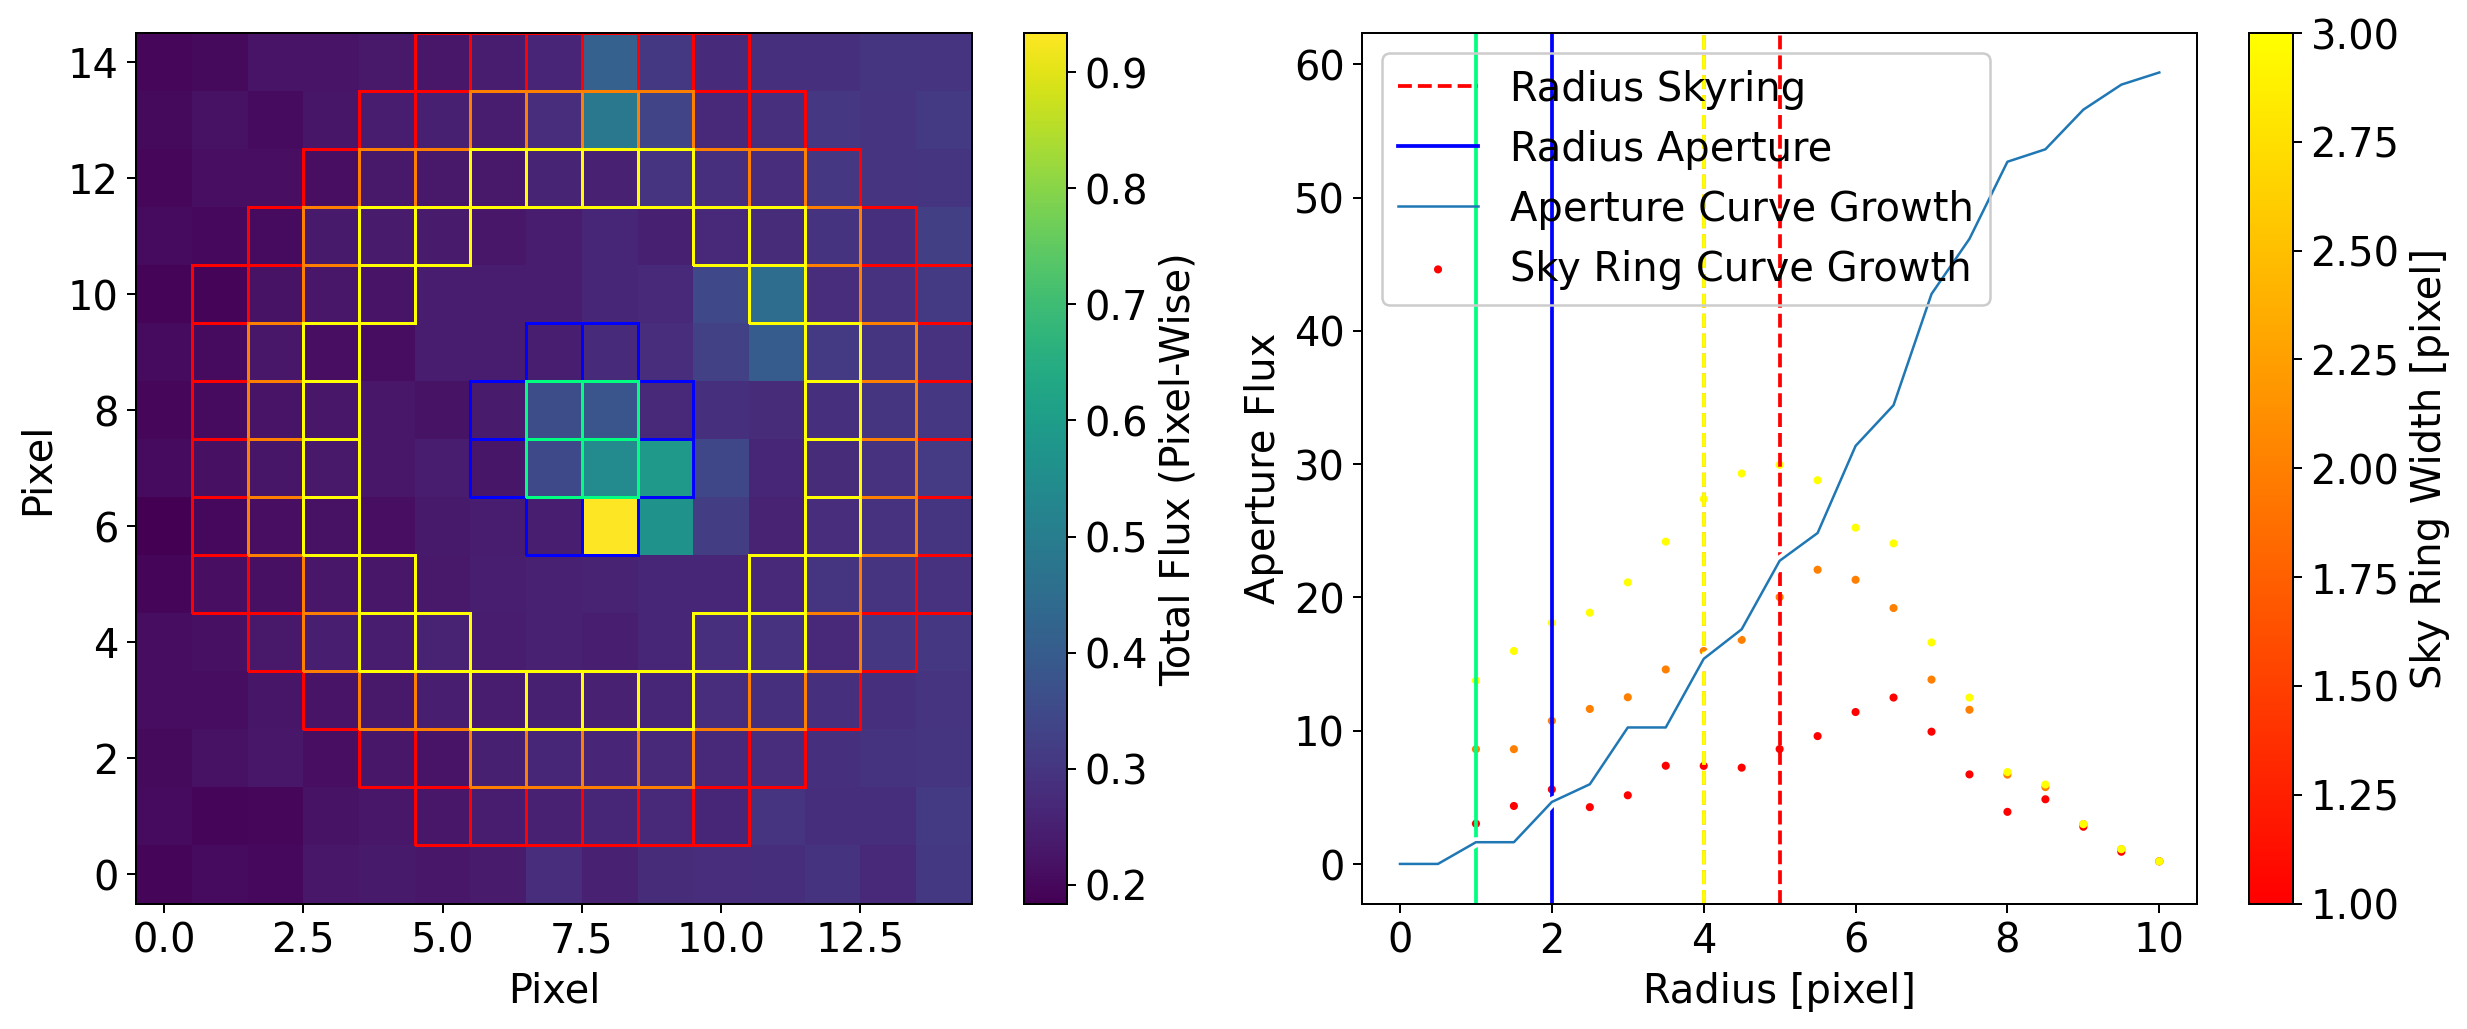

In [13]:
importlib.reload(alprph)
importlib.reload(alsyim)

#test radii of aperture and skyring
r_star = np.linspace(0,10,21)
rw_sky = [[i, j] for i in np.linspace(1,10,19) for j in np.linspace(1,3,3)]
# for rw in rw_sky: print(rw)

#instatiate new estimator
BA = alprph.BestAperture(
    mode='flux',
    # mode='mag',
)
print(BA)


BA.fit(
    x=frames[0],
    posx=7.5, posy=7.5,
    # posx=3, posy=3,
    r_aperture=r_star,
    rw_sky=rw_sky
    # r_sky=r_sky,
    # w_sky=w_sky,
)

# BA.predict()

# BA.fit_predict(
#     frames=frames,
#     posx=7.5, posy=7.5,
#     # posx=3, posy=3,
#     r_aperture=r_star,
#     r_sky=r_sky,
#     w_sky=w_sky,
# )

fig, axs = BA.plot_result(
    plot_aperture_r=np.array([1,2]),
    plot_sky_rings_rw=np.array([[4,2],[4,1],[5,2]]),
    sort_rings_apertures=True,
)


# DifferentialPhotometry

## `DifferentialPhotometryImage`
* Frame-Wise

### Using a Constant Reference Object

/home/lukas/venvs/astroLuSt/lib/python3.10/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


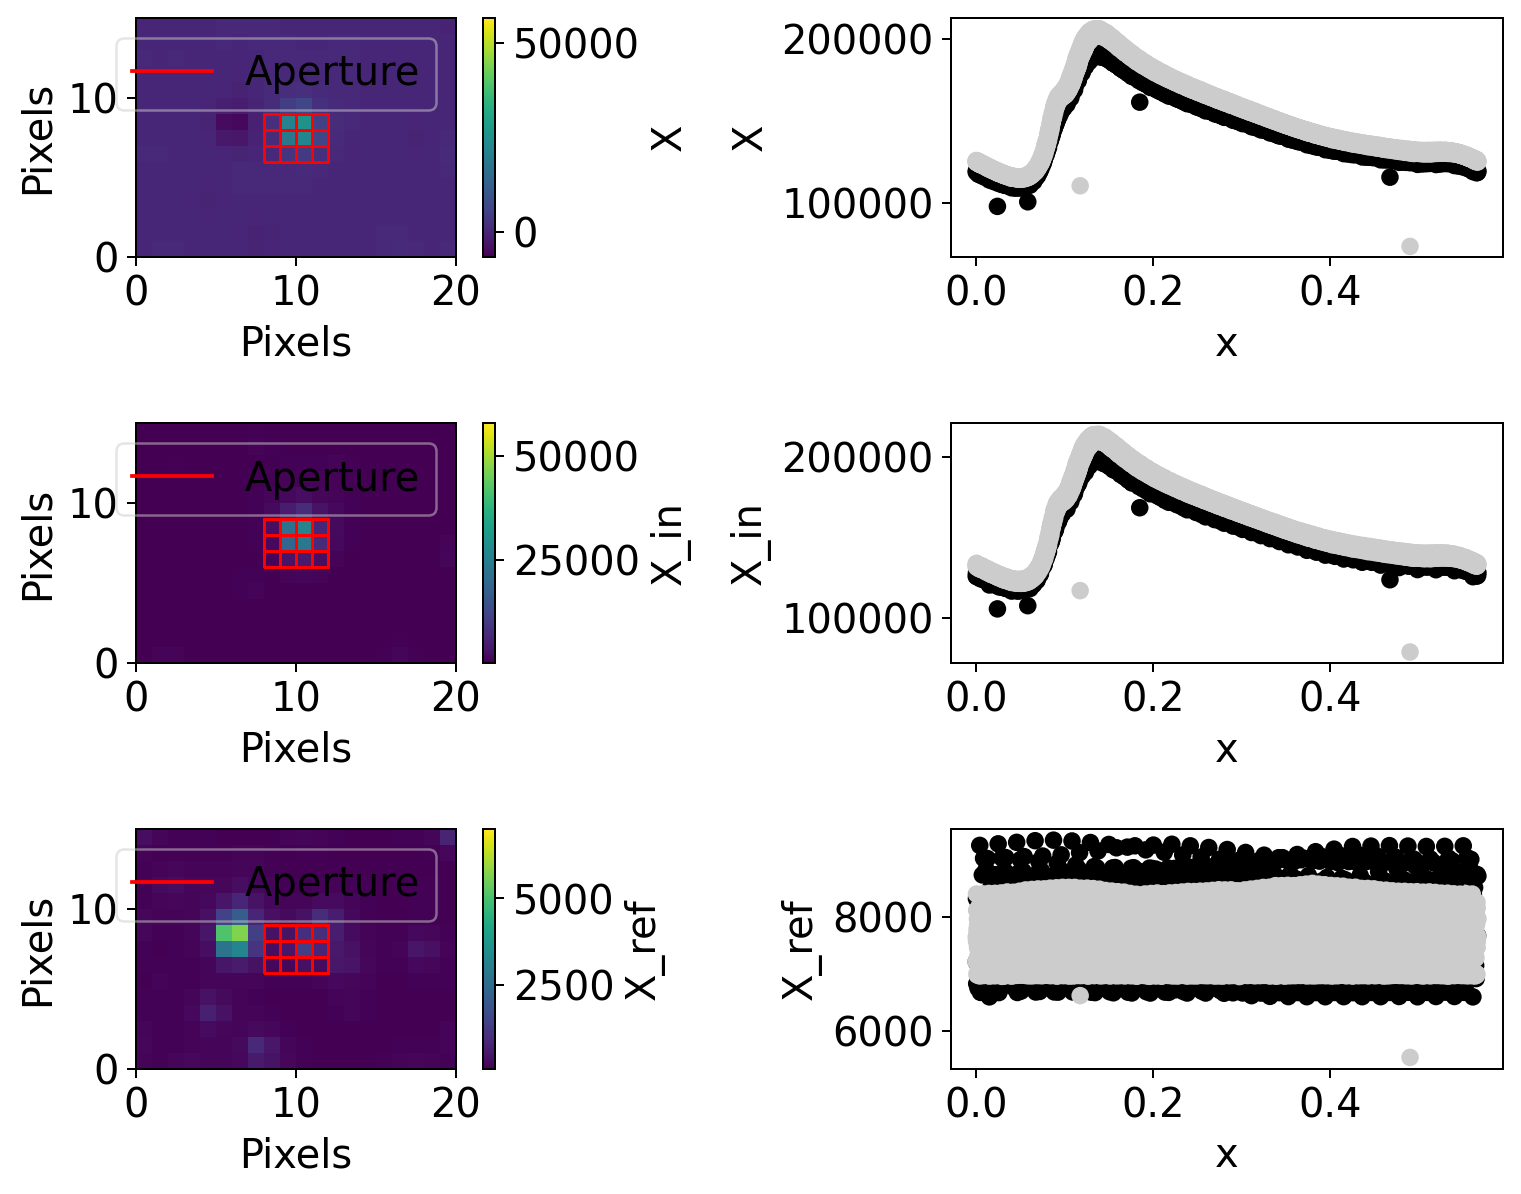

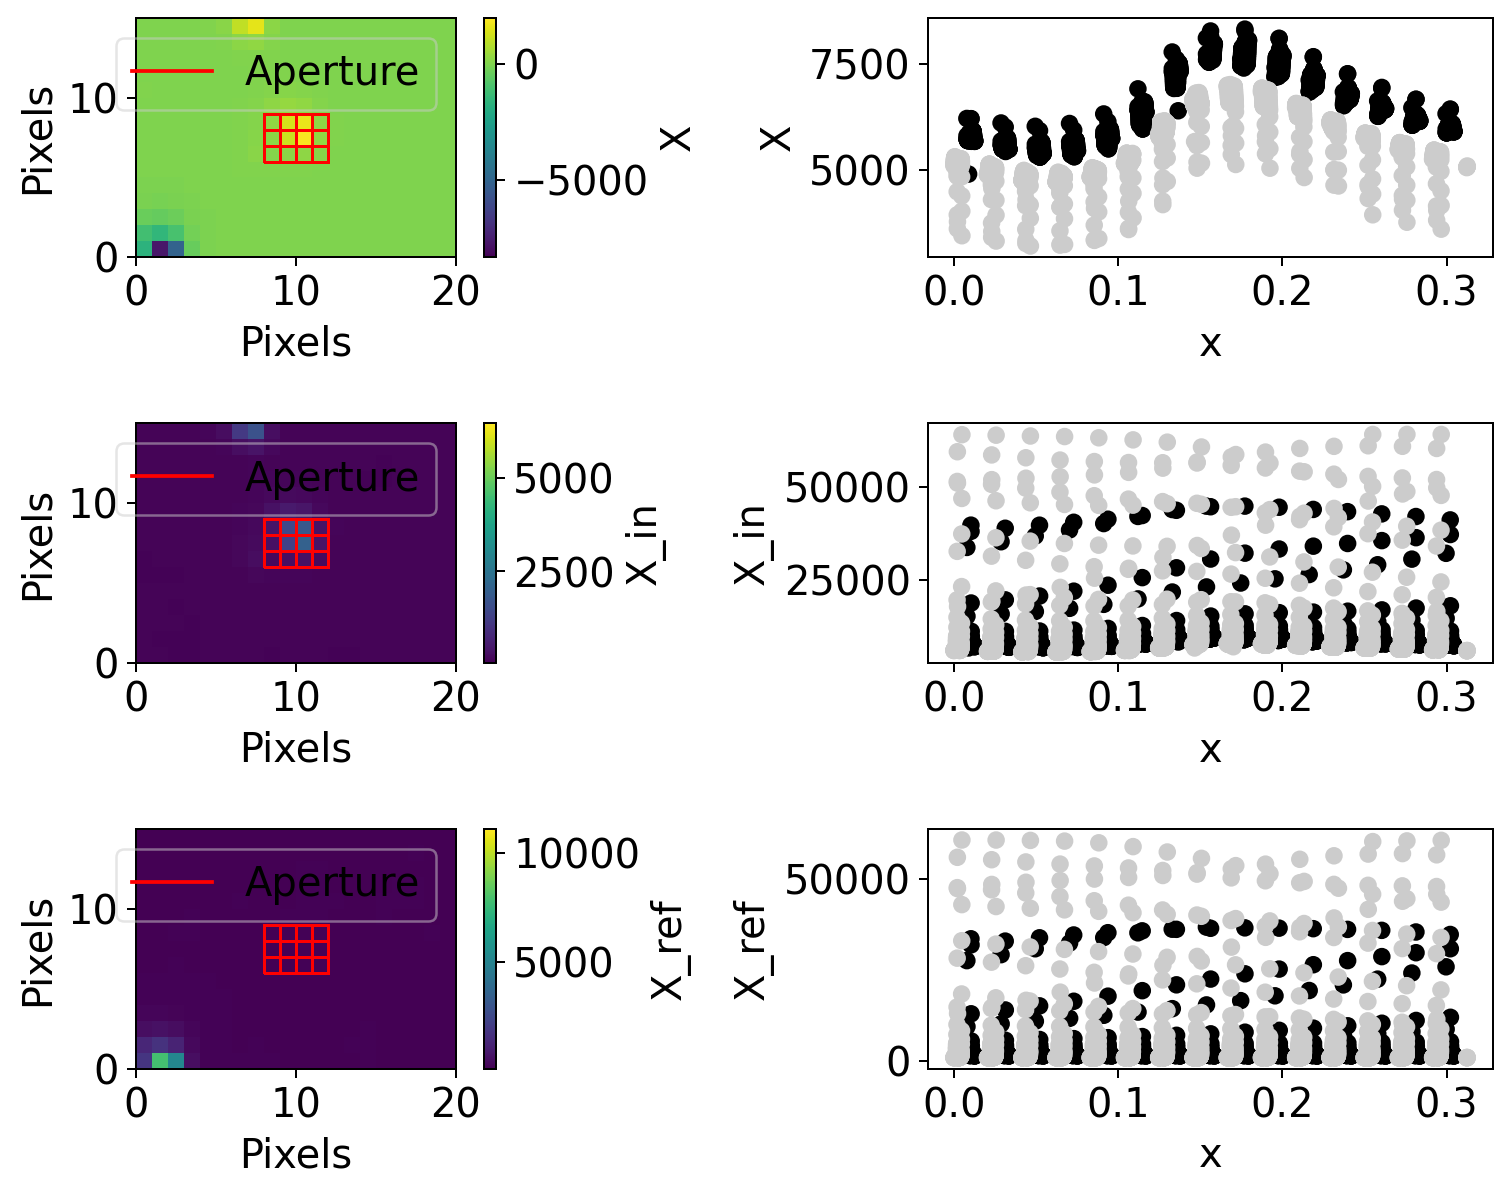

In [14]:
DPI = alprph.DifferentialPhotometryImage()
for idx in range(0,len(tpfs)):

    DPI.fit(
        X=tpfs[idx], X_ref=tpfs_ref[idx],
        X_e=tpfs_e[idx], X_ref_e=tpfs_e_ref[idx],
    )
    tpfs_dpi, tpfs_dpi_e = DPI.transform()

    fig = plt.figure(figsize=(9,7))
    fig, axs, anim = DPI.plot_result(
        X=tpfs_dpi, X_e=tpfs_dpi_e,
        X_in=tpfs[idx], X_in_e=tpfs_e[idx],
        X_ref=tpfs_ref[idx], X_ref_e=tpfs_e_ref[idx],
        x_vals=times[idx]%df_targets["period"][idx],
        aperture=2,
        fig=fig,
        animate=False,
        sctr_kwargs=dict(c=sectors[idx])
    )

plt.show()

### Background Subtraction Via Sky-Ring

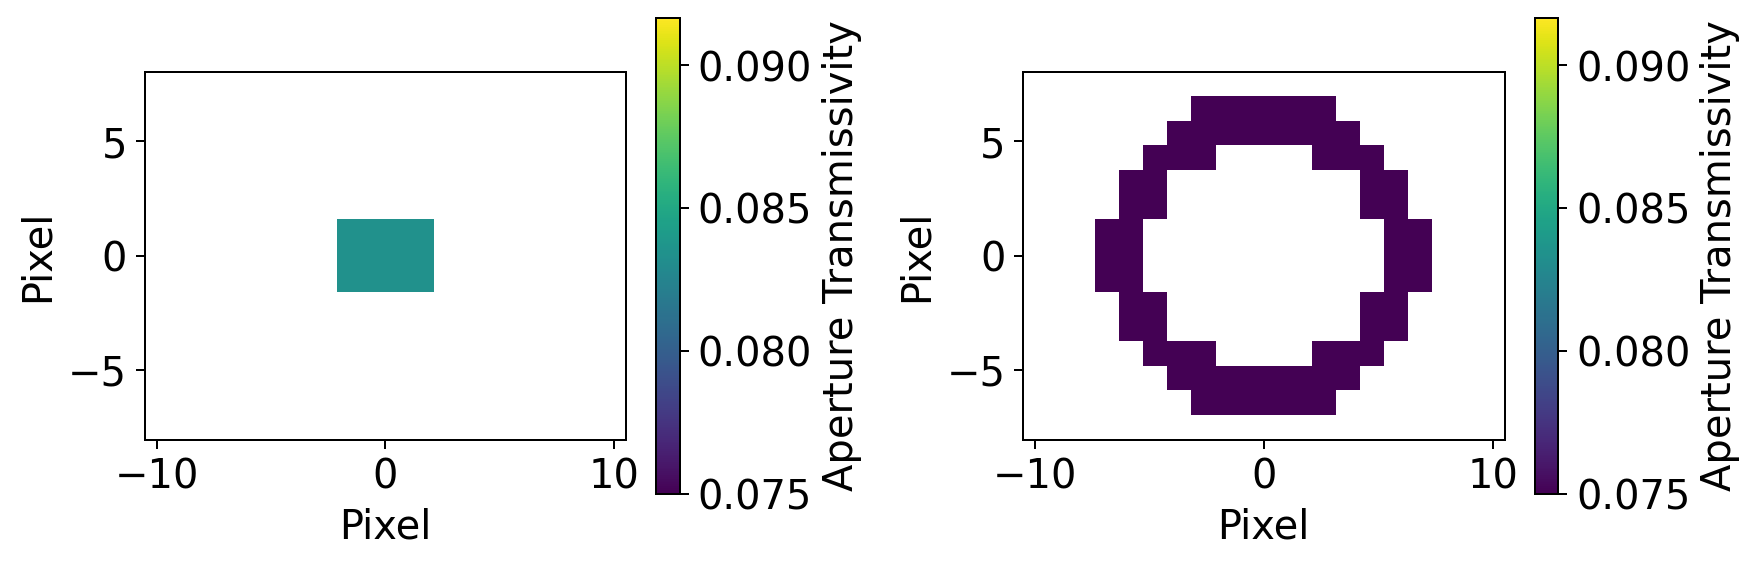

In [15]:
#get apertures
AP = alprph.Aperture(
    size=tpfs[0].shape[1:],
    npixels=1,  #normalize to 1 pixel
    outside=np.nan, #specify outside-aperture values
    position=None,
    verbose=0
)

ap_sc = AP.lp_aperture(radius=2, p=2, radius_inner=0)
ap_bg   = AP.lp_aperture(radius=7, p=2, radius_inner=5)

# print(np.nansum(ap_sc), np.nansum(ap_bg))

fig = plt.figure(figsize=(10,3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig, axs = AP.plot_result(ap_sc,  ax=ax1, pcolormesh_kwargs=dict(vmin=np.nanmin(ap_sc), vmax=np.nanmax(ap_sc)))
fig, asx = AP.plot_result(ap_bg,  ax=ax2, pcolormesh_kwargs=dict(vmin=np.nanmin(ap_sc), vmax=np.nanmax(ap_sc)))
fig.tight_layout()
plt.show()

(5168, 1, 1) (5168, 1, 1)
(2359, 1, 1) (2359, 1, 1)


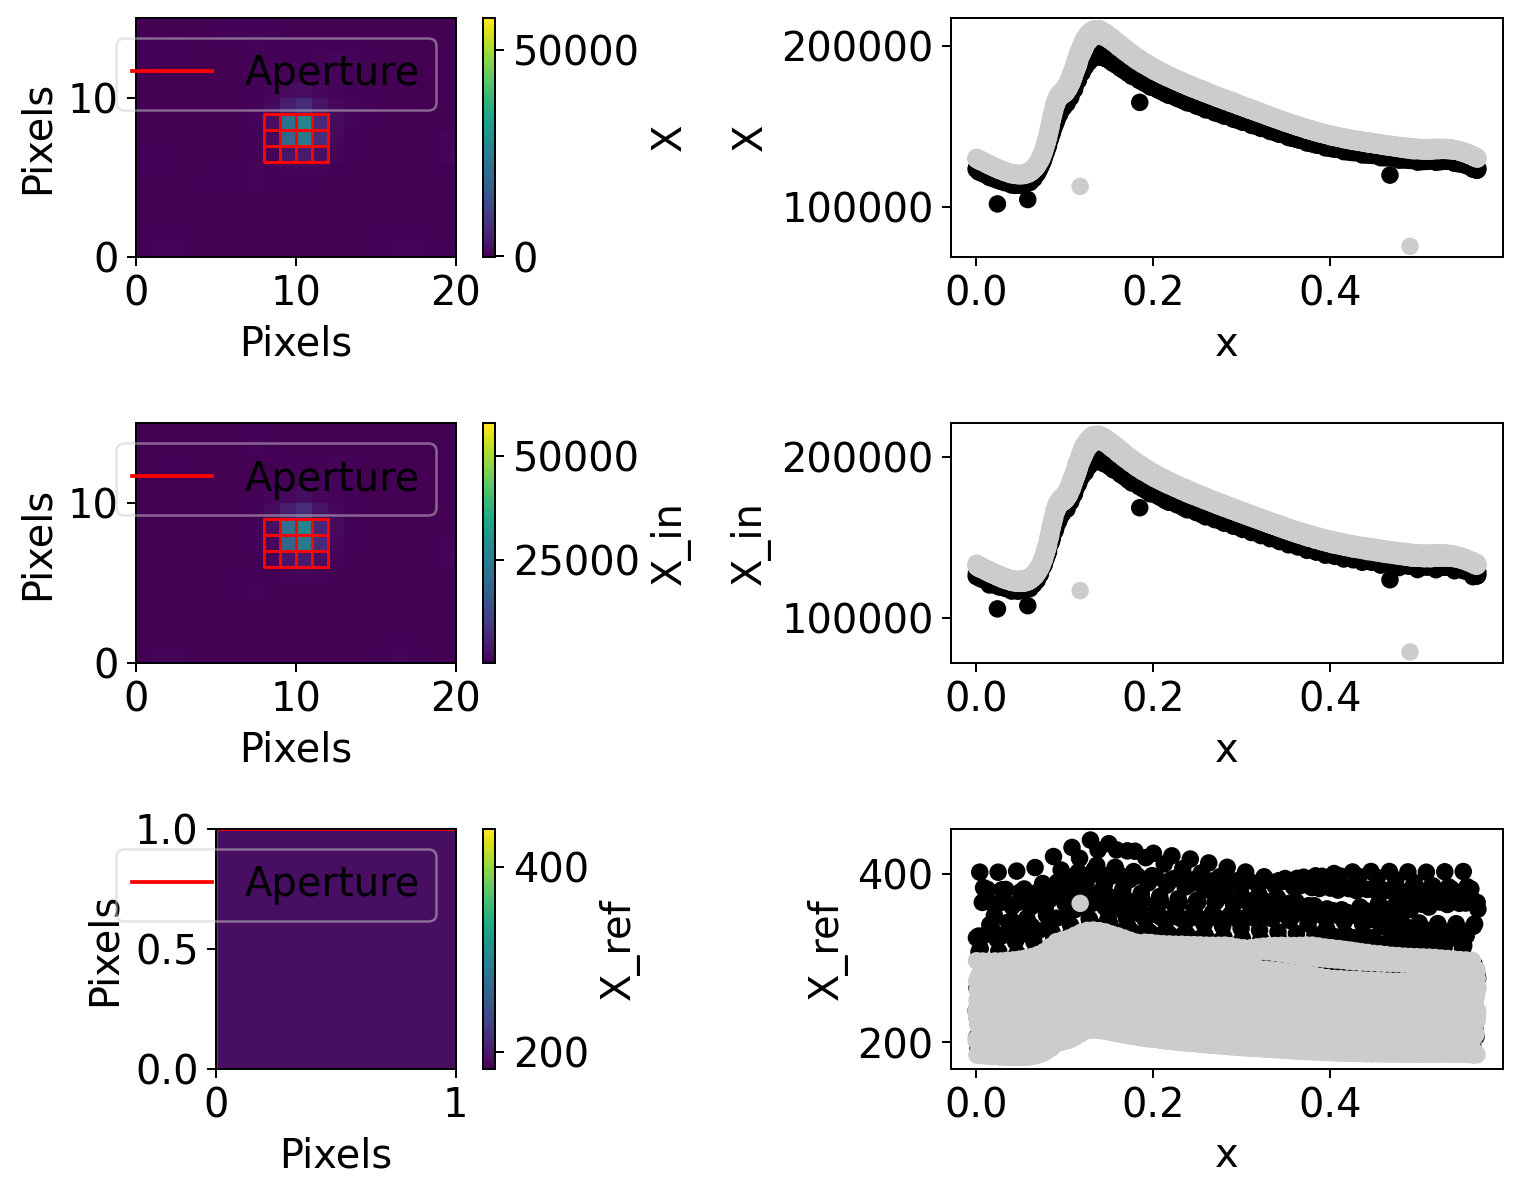

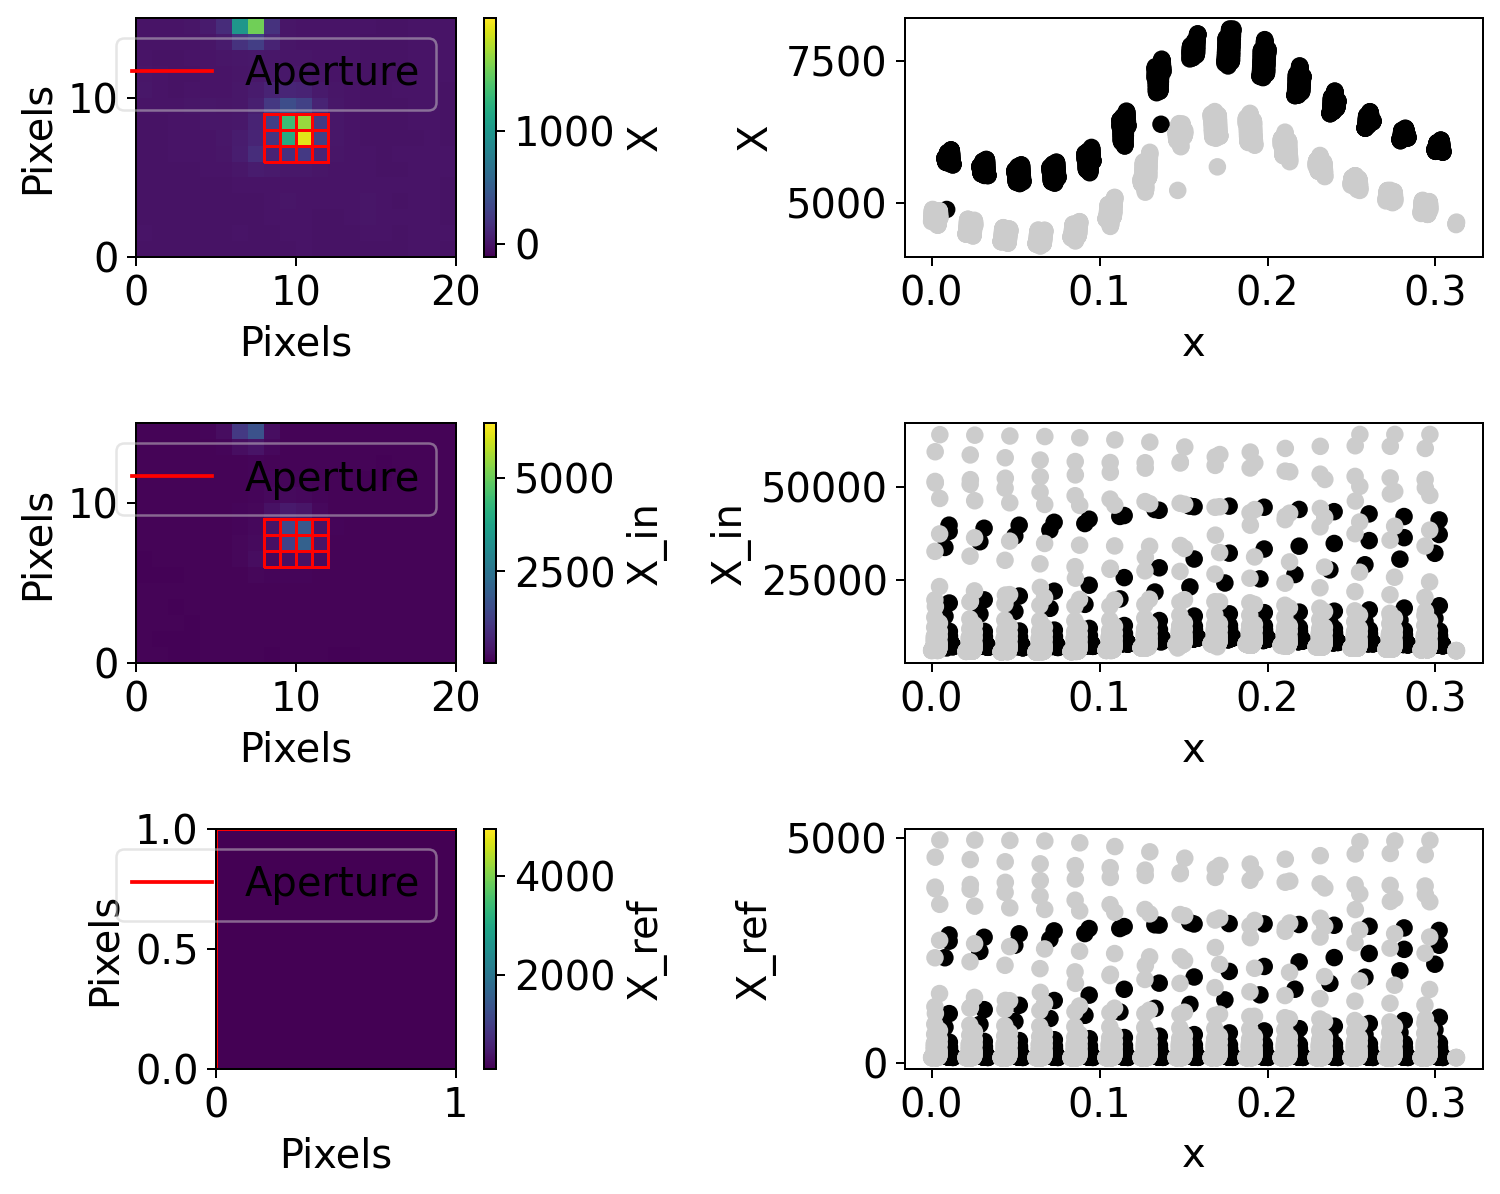

In [ ]:
importlib.reload(alprph)
APH = alprph.AperturePhotometry(verbose=0)
DPI = alprph.DifferentialPhotometryImage()
for idx in range(0,len(tpfs)):

    #get background
    APH.fit(X=tpfs[idx], X_e=tpfs_e[idx], aperture=ap_bg)
    lcs_bg, lcs_bg_e, aps_bg = APH.transform()
    # ap2plot = aps_bg.copy()
    # ap2plot[np.isnan(ap2plot)] = 0
    # fig, axs, anim = APH.plot_result(
    #     X=lcs_bg, X_e=lcs_bg_e,
    #     X_in=tpfs[idx],
    #     aperture=(ap2plot>0),
    #     animate=False
    # )
    
    #expand to 3d to be castable with image
    lcs_bg      = lcs_bg[:,0].reshape(-1,1,1)
    lcs_bg_e    = lcs_bg_e[:,0].reshape(-1,1,1)
    print(lcs_bg.shape, lcs_bg_e.shape)

    #apply differential photometry for backgrund subtraction
    DPI.fit(
        X=tpfs[idx], X_ref=lcs_bg,
        X_e=tpfs_e[idx], X_ref_e=lcs_bg_e,
        # strategy=None,
    )
    tpfs_dpi, tpfs_dpi_e = DPI.transform()
    
    #plot result
    fig = plt.figure(figsize=(9,7))
    fig, axs, anim = DPI.plot_result(
        X=tpfs_dpi, X_e=tpfs_dpi_e,
        X_in=tpfs[idx], X_in_e=tpfs_e[idx],
        X_ref=lcs_bg, X_ref_e=lcs_bg_e,
        x_vals=times[idx]%df_targets["period"][idx],
        aperture=2,
        sctr_kwargs=dict(c=sectors[idx]),
        fig=fig,
        animate=False
    )

    
plt.show()

## `DifferentialPhotometryLC`

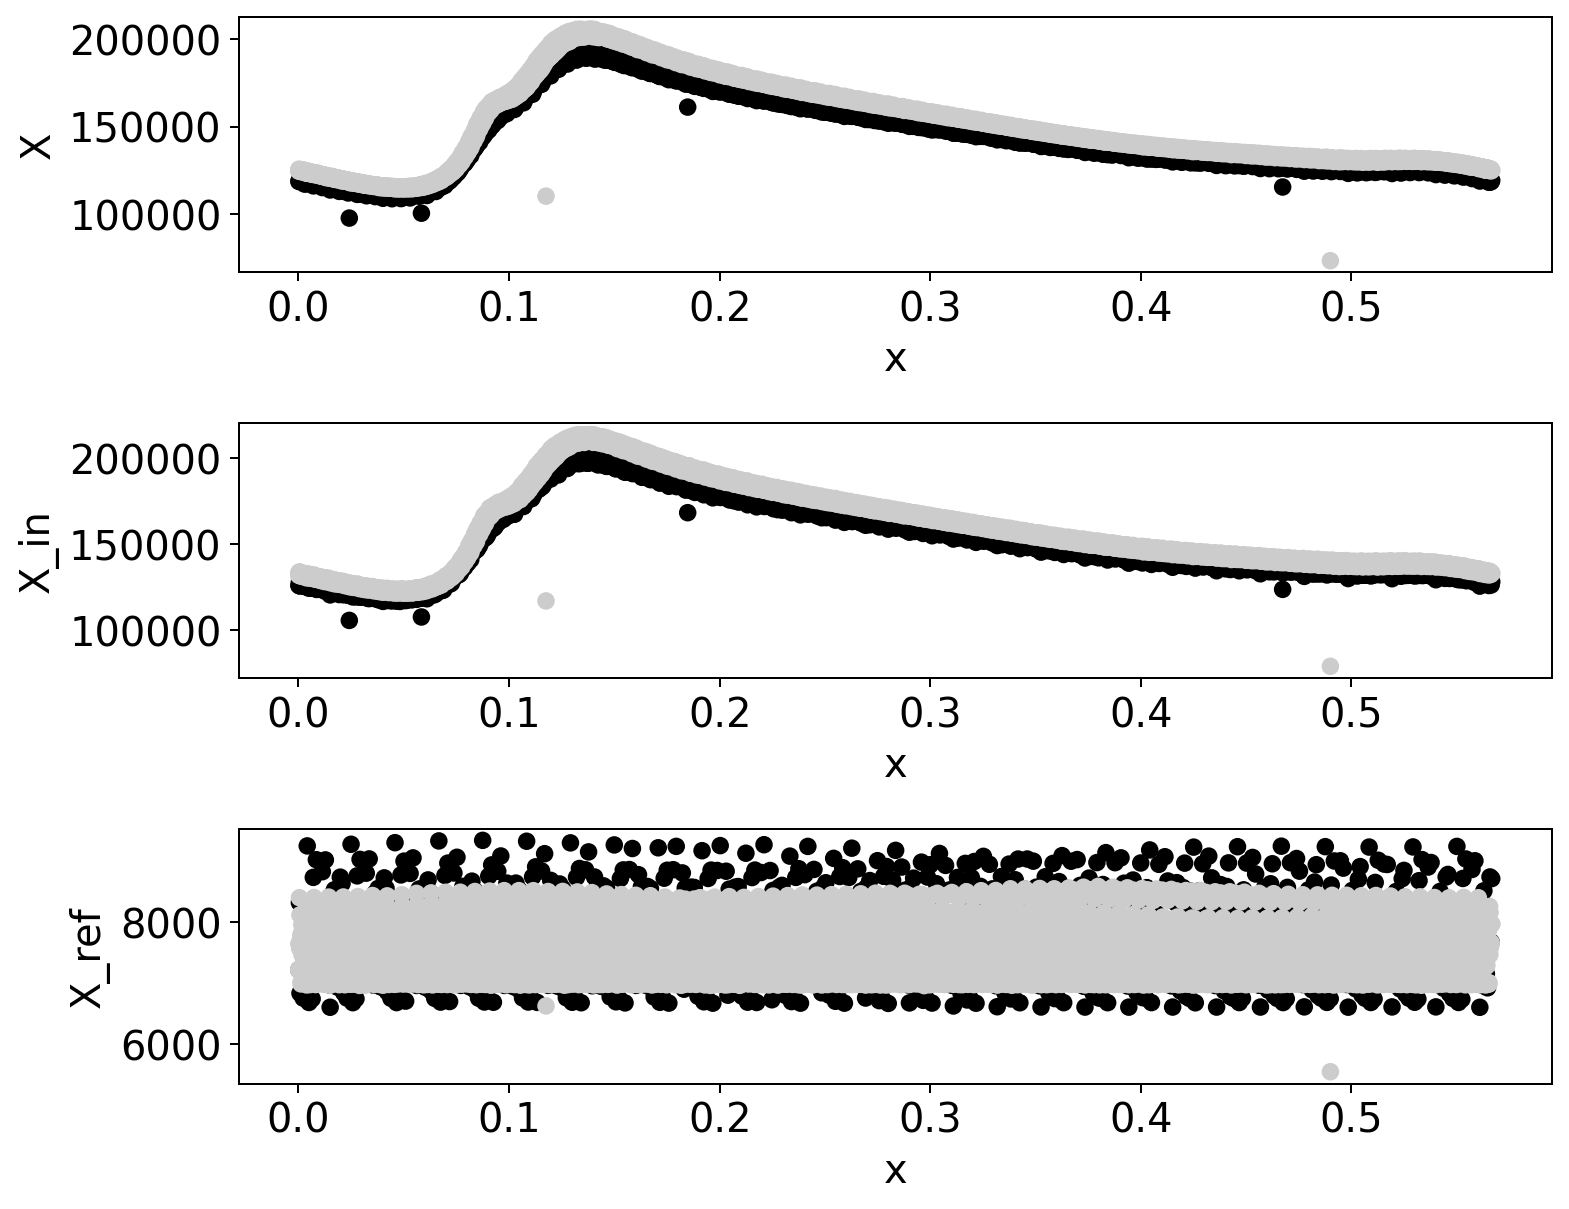

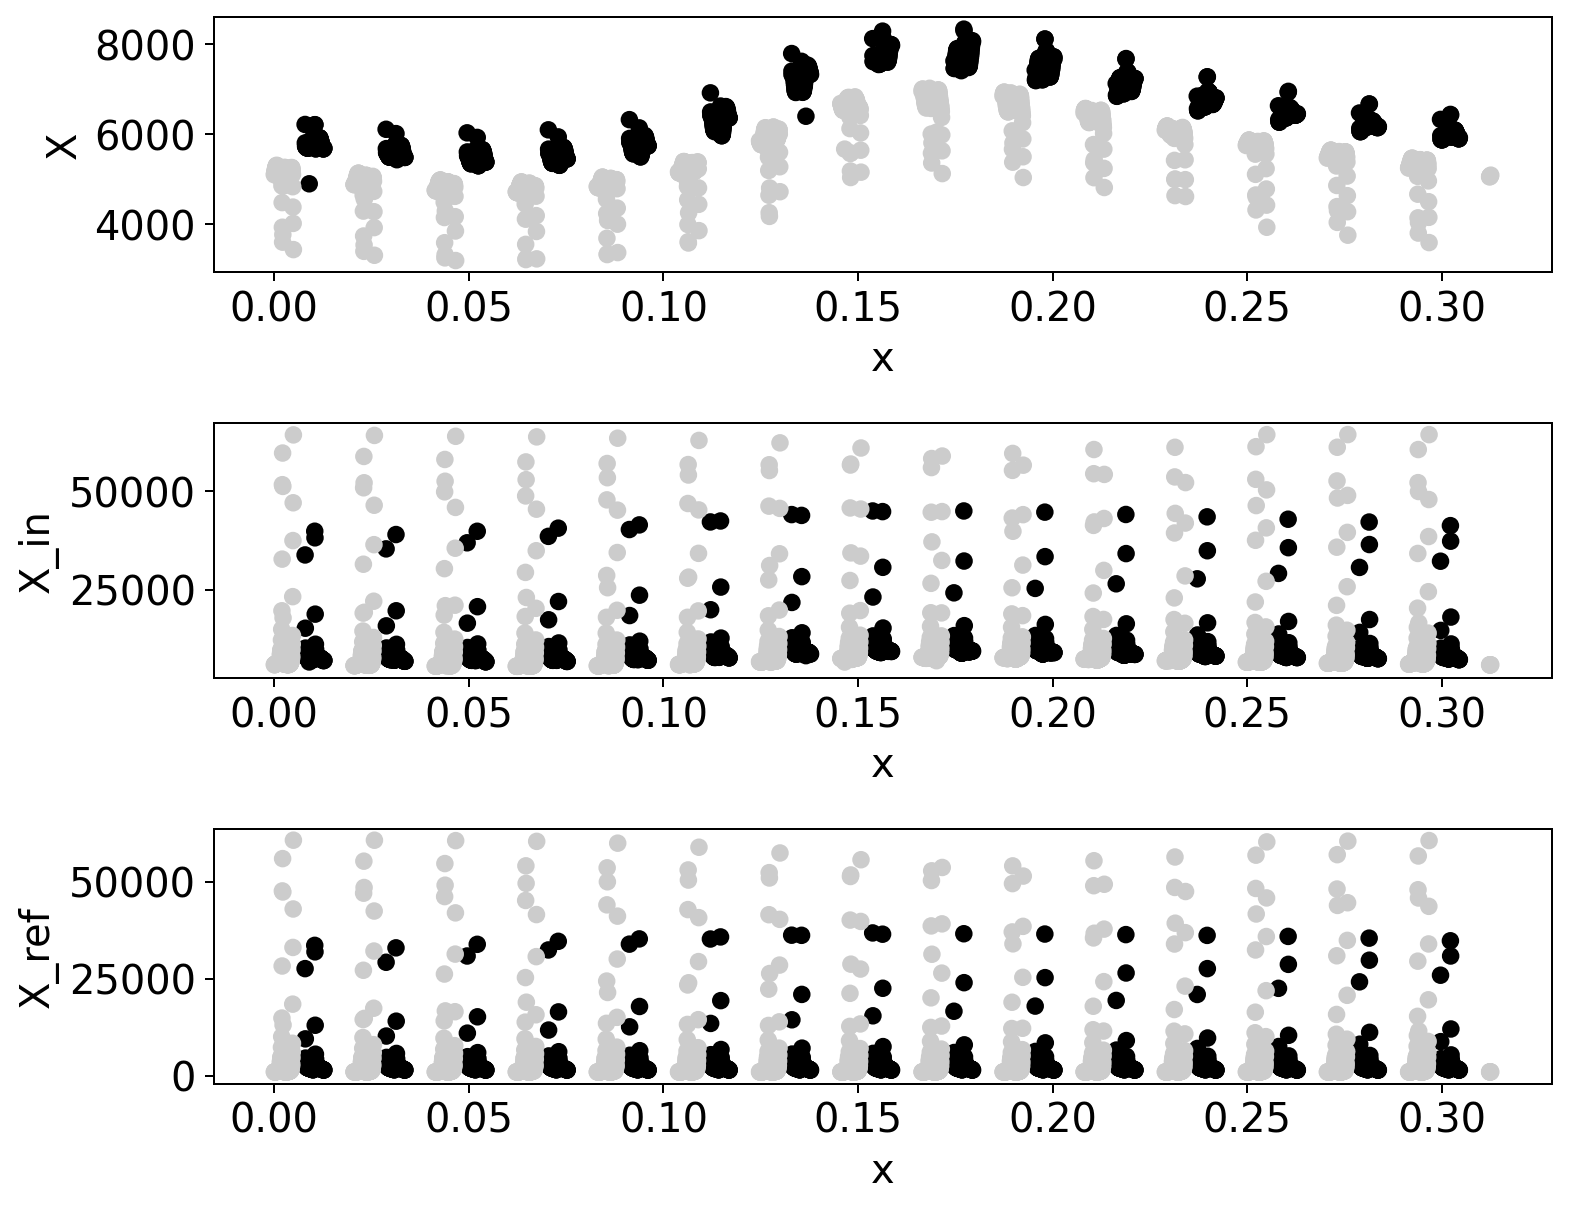

In [17]:
AP = alprph.AperturePhotometry()
DPL = alprph.DifferentialPhotometryLC()

for idx in range(len(tpfs)):
    #get LC of science object
    AP.fit(X=tpfs[idx], X_e=tpfs_e[idx], aperture=2)
    lc, lc_e, aps = AP.transform()
    lc, lc_e, aps = lc[:,0], lc_e[:,0], aps[:,0]    #select what flux to use

    #get LC of reference object
    AP.fit(X=tpfs_ref[idx], X_e=tpfs_e_ref[idx], aperture=2)
    lc_ref, lc_e_ref, aps_ref = AP.transform()
    lc_ref, lc_e_ref, aps_ref = lc_ref[:,0], lc_e_ref[:,0], aps_ref[:,0]    #select what flux to use

    # print(lc.shape, lc_ref.shape)

    #apply differential photometry
    DPL.fit(
        X=lc, X_ref=lc_ref,
        X_e=lc_e, X_ref_e=lc_e_ref
    )
    lc_dpl, lc_e_dpl = DPL.transform()
    
    #plot
    fig = plt.figure(figsize=(9,7))
    fig, axs = DPL.plot_result(
        X=lc_dpl, X_e=lc_e_dpl,
        X_in=lc, X_in_e=lc_e,
        X_ref=lc_ref, X_ref_e=lc_e_ref,
        fig=fig,
        x_vals=times[idx]%(df_targets["period"][idx]),
        sctr_kwargs=dict(c=sectors[idx]),
    )

plt.show()
    